# Prepare KITTI dataset
We used KITTI object 2D for training DETR model.
---
## Download data and labels
Download KITTI object 2D left color images of object data set (12 GB) and submit your email address to get the download link. Download training labels of object data set (5 MB). Unzip them to your customized directory <data_dir> and <label_dir>.
your downloaded data should be organized in this structure:

```
.
|--dataset root
  |-- images
      |-- 000000.jpg
      |-- 000001.jpg
            .
            .
      |-- xxxxxx.jpg
  |-- labels
      |-- 000000.txt
      |-- 000001.txt
            .
            .
      |-- xxxxxx.txt
```
---
## split data in train and val

In [ ]:
from datasets.dataset_split import split_dataset

split_dataset("${your dataset root path}")

After split, your data structure will be converted to:
```
.
|--dataset root
  |-- train
      |-- 000000.jpg
      |-- 000001.jpg
            .
      |-- xxxxxx.jpg
  |-- val
      |-- 000003.jpg
      |-- 000006.jpg
            .
      |-- xxxxxx.jpg
  |-- labels
      |-- 000000.txt
      |-- 000001.txt
            .
      |-- xxxxxx.txt
```

---
## convert KITTI data format
DETR model is trained on COCO dataset in our codebase. COCO dataset's label is described in JSON, but KITTI label is described in txt. So, convert data format in COCO dataset.

In [ ]:
from datasets.kitti_to_coco import convert_kitti_to_coco

convert_kitti_to_coco("${your dataset root path}")

Now, your data structure will be like this:
```
.
|--dataset root
  |-- train
      |-- 000000.jpg
      |-- 000001.jpg
            .
      |-- xxxxxx.jpg
  |-- val
      |-- 000003.jpg
      |-- 000006.jpg
            .
      |-- xxxxxx.jpg
  KITTI_train.json
  KITTI_val.json
  |-- labels
      |-- 000000.txt
      |-- 000001.txt
            .
      |-- xxxxxx.txt
```
All data labels are converted in these two files: KITTI_train.json and KITTI_val.json. The original labels directory will be no longer sued. You can remove it if you like.

---
# training
We need GPU in this step. Make sure your GPU is available.

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


If you don't have available GPU for training. We recommend you using sharing GPU on Google Colab. If so you  have to upload your code source and dataset on Google Drive (this is one way to let your colab can access your dataset and code). Then you need to mount Google Drive on colab. If you don't use colab or you have other ways, skip this step.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

Start training your model on KITTI dataset

In [ ]:
!source KITTI/project/venv/bin/activate

In [ ]:
!python3 KITTI/project/main.py --data_path KITTI/dataset/ --output_dir KITTI/output --epochs 180 --resume https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth &

---
# Evaluation
---
## Visualize training record
we can visualize our training record using following commands.
Solid lines are training results. Dashed lines are validation results.
Note that, args.output_dir is the path of your training records.

plot_utils.py::plot_logs info: logs param expects a list argument, converted to list[Path].


/Users/liuhangfan/PycharmProjects/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(
/Users/liuhangfan/PycharmProjects/detr/util/plot_utils.py:65: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['test_coco_eval_bbox'], dtype='object')
  df.interpolate().ewm(com=ewm_col).mean().plot(


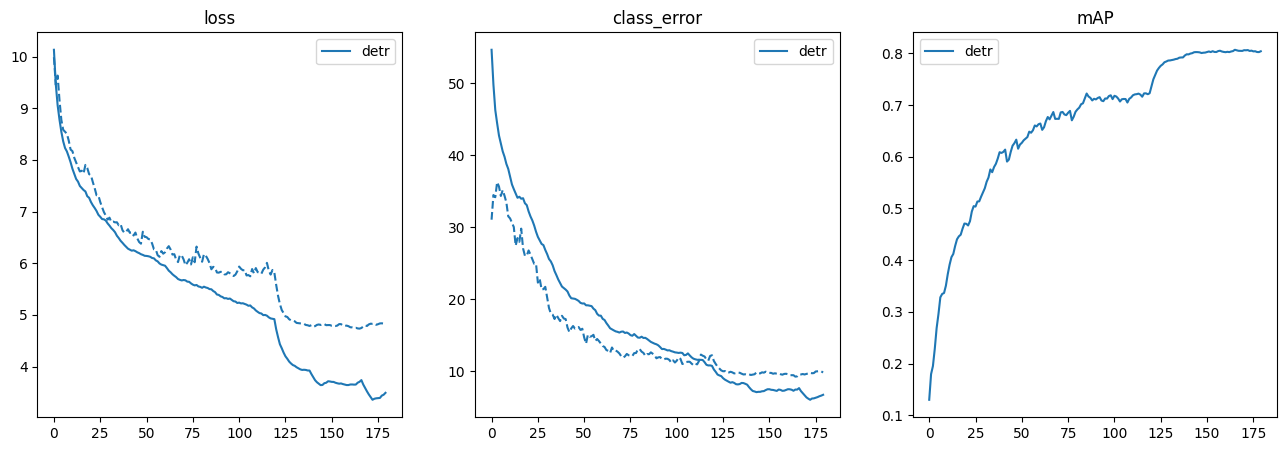

In [2]:
from util.plot_utils import *
from pathlib import Path
fields = ('loss', 'class_error','mAP')  # <-- put the items of interest here
path = Path.cwd()/'./'  # <--- set path to your args.output_dir
plot_logs(path, fields,ewm_col=2)

---
## Visualize inference samples

/Library/Python/3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Python/3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


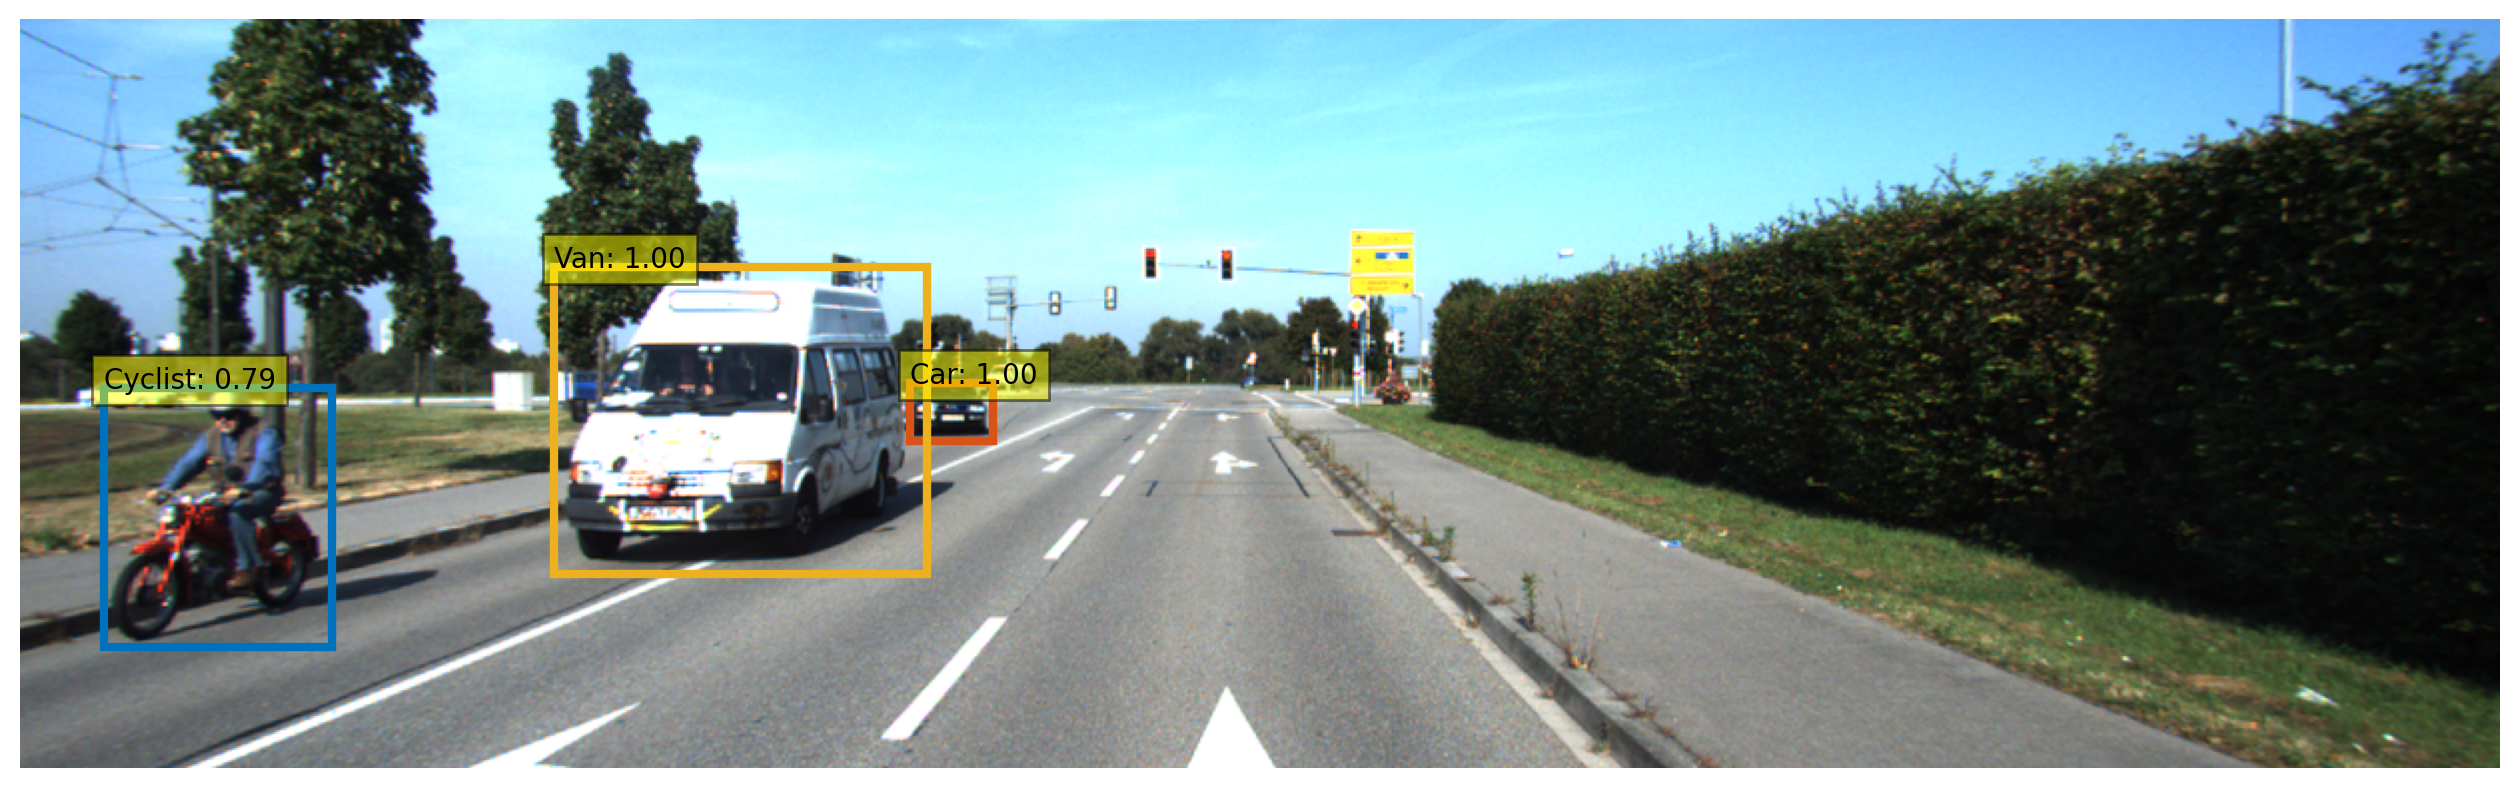

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import torch
import torchvision.transforms as T
torch.set_grad_enabled(False);
# KITTI classes
CLASSES = ['N/A', 'Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc', 'DontCare']

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=10,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

from hubconf import _make_detr
model = _make_detr("resnet50", dilation=False, num_classes=10)
checkpoint = torch.load("checkpoint.pth", map_location="cpu")
model.load_state_dict(checkpoint["model"])
model.eval()

im = Image.open("resource/sample_1.png")

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.78

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

---
## Visualize encoder-decoder multi-head attention weights
Here we visualize attention weights of the last decoder layer. This corresponds to visualizing, for each detected objects, which part of the image the model was looking at to predict this specific bounding box and class.
We will use hooks to extract attention weights (averaged over all heads) from the transformer.

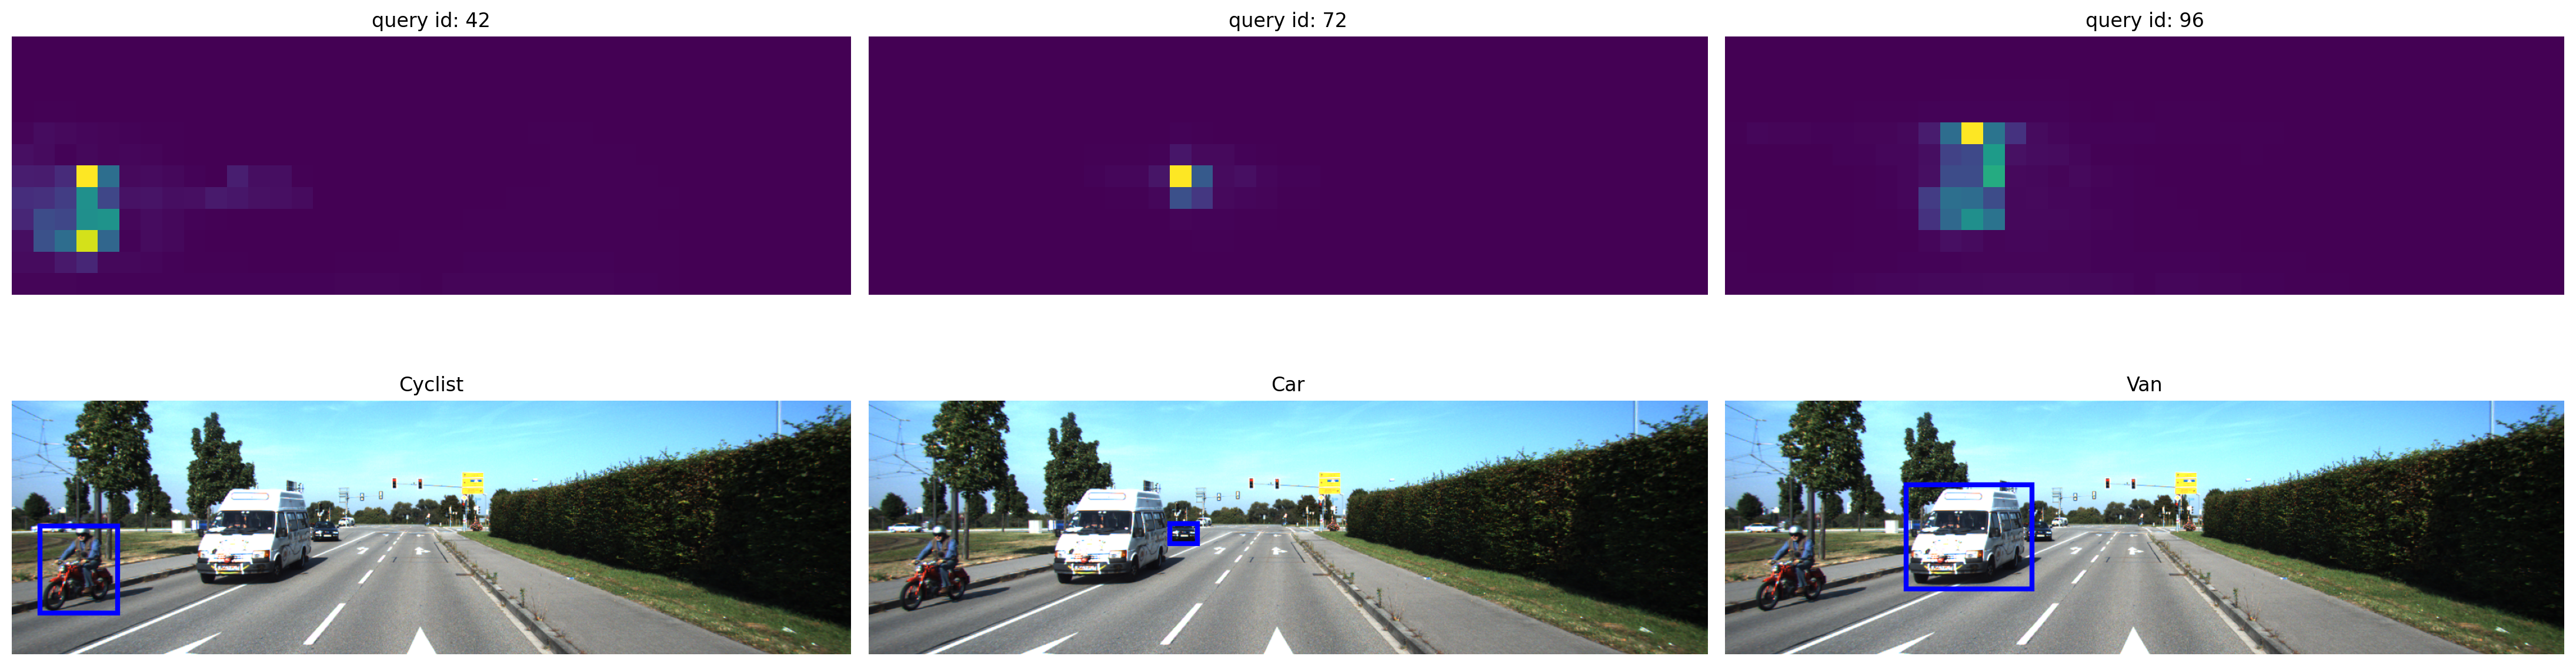

In [11]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img)

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()